**SMA (Simple Moving Average) crossover strategy**

It is a type of **Trend Following** (momentum) strategy and onsists of a **leading** and a **lagging** simple moving averages.
Leading SMA has a **shorter look-back period** than lagging moving average. Hence, by definition, leading SMA will be more sensitive to most recent price moves; lagging SMA will be slower to react

*  **LONG**: if Leading (short-term) SMA cross above Lagging SMA
*  **SHORT**: if Leading (long-term) SMA cross below Lagging SMA

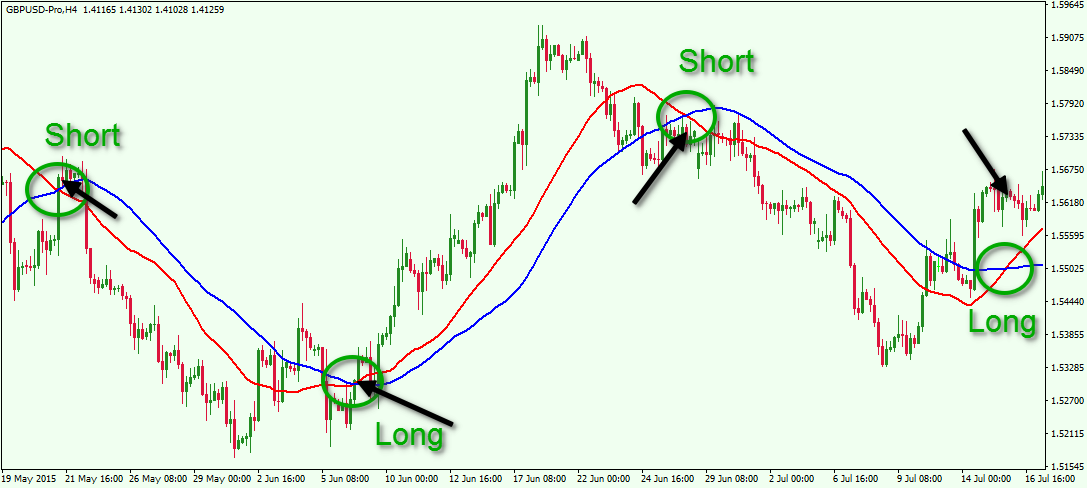


In [ ]:
#@title Execute this block to start importing the libraries and helper functions

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None


#!pip install pyfolio
!pip install -q git+https://github.com/quantopian/pyfolio
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Interative charting
import altair as alt
alt.data_transformers.disable_max_rows()

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()

    # build the lead/lag indicator
    ma_df['lead'] = ma_df['Close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['Close'].rolling(lag).mean()

    # Remove the NaN rows
    ma_df.dropna(inplace = True)

    # calculate the lead and lag difference
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['Close']

    # signal column will govern the buying and selling logic as described above;
    # 1 means that we are long, -1 means that we are short and 0 means no position
    ma_df['signal'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['signal'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['signal'])

    # Market column as log returns of price series - which is the simple buy-and-hold performance
    ma_df['Buy-Hold'] = np.log(ma_df['Close'] / ma_df['Close'].shift(1))

    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column
    ma_df['Strategy'] = ma_df['signal'].shift(1) * ma_df['Buy-Hold']

    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns
    # in order to recover the original normalised series
    ma_df[['Buy-Hold','Strategy']] = ma_df[['Buy-Hold','Strategy']].cumsum().apply(np.exp)
    return ma_df


import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the OHLCV chart
def ohlcv(df, date, open, high, low, close, volume):
	rDf = df.reset_index()

	# Create subplots and mention plot grid size
	fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
				   vertical_spacing=0.03,
				   subplot_titles=('OHLC', 'Volume'),
				   row_width=[0.2, 0.7])

	fig.add_trace(go.Ohlc(x=rDf[date],
					  open=rDf[open],
					  high=rDf[high],
					  low=rDf[low],
					  close=rDf[close],
					  name="OHLC"),
					  row=1, col=1)

	# Bar trace for volumes on 2nd row without legend
	fig.add_trace(go.Bar(x=rDf[date], y=rDf[volume], showlegend=False), row=2, col=1)

	# Do not show OHLC's rangeslider plot
	fig.update(layout_xaxis_rangeslider_visible=False)

	fig.show()

In [ ]:
#@title 1: Download historical Bitcoin daily data from Yahoo Finance

import yfinance as yf
stock = yf.Ticker("BTC-USD")

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
startDate = '2011-1-1'

df= stock.history(start=startDate)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

''' In case Yahoo doesn't work, download from the github
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/bitcoinHistorical.csv'
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
'''

df

In [ ]:
# Save the dataframe to csv for downloading
df.to_csv('bitcoinHistorical.csv')

#2: Visualize and understand the data (Exploratory Data Analysis)
Plot OHLCV (Open/High/Low/Close/Volume) candle sticks

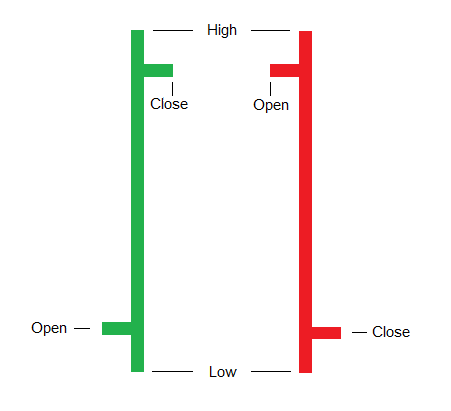

In [ ]:
# Filter the start date
#df = df.loc['2018-01-01':]

ohlcv(df, 'Date', 'Open', 'High', 'Low', 'Close', 'Volume')

In [ ]:
# look at price volatility (closing price change) summary statistics
print(df['Close'].pct_change().describe())
df['Close'].pct_change().hist(bins=100)

In [ ]:
lead = 45 # short-term moving average days
lag = 125 # long-term moving average days

df['lead'] = df['Close'].rolling(lead).mean()
df['lag'] = df['Close'].rolling(lag).mean()

COLUMNS = ['Close', 'lead', 'lag']
df[COLUMNS]

In [ ]:
#@title Plot the SMA cross over
# Rearrange the data into altair format
# altair plots interactive charts with zooming and panning
plot_data = df[COLUMNS].reset_index().melt('Date')

alt.Chart(plot_data).mark_line().encode(
  x='Date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()

#3: Back testing the strategy with the historical data

Strategy Signal: (1, -1, 0)

*   **1 LONG**: if Leading SMA is above Lagging SMA by the threshold -> hold 1 long position of bitcoin
*   **-1 SHORT**: if Leading SMA is below Lagging SMA by the threshold -> short 1 bitcoin
*   **0 FLAT**: if the difference of Leading and Lagging SMA is less than the threshold -> flatten the bitcoin position


Back testing parameters
*   **lead**: short-term moving average days
*   **lag**: long-term moving average days
*   **threshold**: sensitivity of the strategy and is used to filter out weak signals. **Smaller the number means more sensitive** to the signals (which usually means more long/short positions)

In [ ]:
#@title Run back testing with different parameters

lead = 45 #@param {type:"integer"}
lag = 125 #@param {type:"integer"}
threshold = 0.1 #@param {type:"slider", min:0, max:0.5, step:0.01}

ma_df = test_ma(df, lead, lag, threshold).dropna()

SMA_COLUMNS = ['Close', 'lead', 'lag', 'lead-lag', 'pc_diff', 'signal', 'Buy-Hold', 'Strategy']
ma_df[SMA_COLUMNS]

In [ ]:
#@title Plot the back test result
# Plot signal over "lead-lag" price difference (align at 0)
# Plot signal as the left y-axis
ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['short', 'flat', 'long'])

# Plot "lead-lag" price difference as the right y-axis
ax2 = ma_df.pc_diff.plot(secondary_y=True, label='Lead-Lag Px Diff', legend=True, figsize=(SCREEN_X, SCREEN_Y))
SAFE_MARGIN = 0.05
ylimit = max(round(ma_df.pc_diff.max(), 1), - round(ma_df.pc_diff.min(), 1)) + SAFE_MARGIN
ax2.set_ylim(-ylimit, ylimit)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')

In [ ]:
# Compare Buy-hold vs SMA Strategy performance

ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

In [ ]:
# Plot Buy-Hold vs SMA Strategy performance

# buy_and_hold strategy which benefit from soaring bitcoin price
# Strategy: SMA crossover long/short which can benefit from both soaring and dropping bit coin price
# (provided that the SMA predicted the price movement correctly)

ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)

#4. Backtest the strategy with different combination to find the optimal lead/lag params

In [ ]:
# start, end, step
leads = np.arange(5, 100, 5)
lags = np.arange(105, 200, 5)

lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)
pnls

In [ ]:
# Run the strategy with the different combination of lead/lag params
# Calculate the different between market Buy-Hold and strategy performance as PnL
for lead, lag in lead_lags:
  ma_df = test_ma(df, lead, lag, threshold)
  pnls[lead][lag] = ma_df['Strategy'][-1] - ma_df['Buy-Hold'][-1]
  print(lead, lag, pnls[lead][lag])

pnls

In [ ]:
# Use Heatmap to visualize the backtest results
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (SCREEN_X, SCREEN_Y))
sns.heatmap(PNLs, cmap='coolwarm', annot=True, cbar_kws={'orientation': 'horizontal'})

In [ ]:
# Run again with the best lead/lag SMA combinations
lead = 5
lag = 105

ma_df = test_ma(df, lead, lag, threshold).dropna()
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

#5. Show the performance details of SMA strategy

In [ ]:
pf.create_full_tear_sheet(ma_df['Strategy'].pct_change())

**Suggestions**

1. Backtest with different threshold values
2. Use other cryptos (e.g. ETH-USD) as correlations to form a better strategy
3. Separate the data into 2 portions (research & back-test). Optimize the lead/lag/threshold params from the research portion and use back-test data to measure the strategy performance
4. Try different data source: https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/DataSource.ipynb
5. Try different TA signals such as RSI, Bollinger Bands with TA-Lib (https://pypi.org/project/TA-Lib/)